# Neural network classifier for mushrooms

In [ ]:
!pip install tensorflow==2.9.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth
from keras.utils import image_dataset_from_directory

In [ ]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

tf.__version__


'2.9.3'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the Dataset
!unzip /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip

Archive:  /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip
   creating: Dataset_4c_avg/test/
   creating: Dataset_4c_avg/test/Amanita/
  inflating: Dataset_4c_avg/test/Amanita/006_862rFWvLb4I.jpg  
  inflating: Dataset_4c_avg/test/Amanita/008_euaqSUZFtMY.jpg  
  inflating: Dataset_4c_avg/test/Amanita/016_S-Z6ZIo2G3k.jpg  
  inflating: Dataset_4c_avg/test/Amanita/018_fu20lV1Ks10.jpg  
  inflating: Dataset_4c_avg/test/Amanita/019_dC7dMPodoSA.jpg  
  inflating: Dataset_4c_avg/test/Amanita/021_2-PKYWYCnqU.jpg  
  inflating: Dataset_4c_avg/test/Amanita/029_EZRk61kOaKI.jpg  
  inflating: Dataset_4c_avg/test/Amanita/033_p_kC9KT-lGU.jpg  
  inflating: Dataset_4c_avg/test/Amanita/037_xyM5ztH9BRk.jpg  
  inflating: Dataset_4c_avg/test/Amanita/050_ag9Ii9vTCdA.jpg  
  inflating: Dataset_4c_avg/test/Amanita/058_qwNykVN8aEo.jpg  
  inflating: Dataset_4c_avg/test/Amanita/069_szzmCkEtJbo.jpg  
  inflating: Dataset_4c_avg/test/Amanita/071_SDRvTCrFXG8.jpg  
  inflating: Dataset_4c_avg/test/A

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [ ]:
physical_devices = list_physical_devices('GPU')
print(f'Number of GPUs available: {len(physical_devices)}')

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

Number of GPUs available: 1


In [ ]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 299
BATCH_SIZE = 64

## Loading and processing data

In [ ]:
data_path = './Dataset_4c_avg/'

Class used: 4


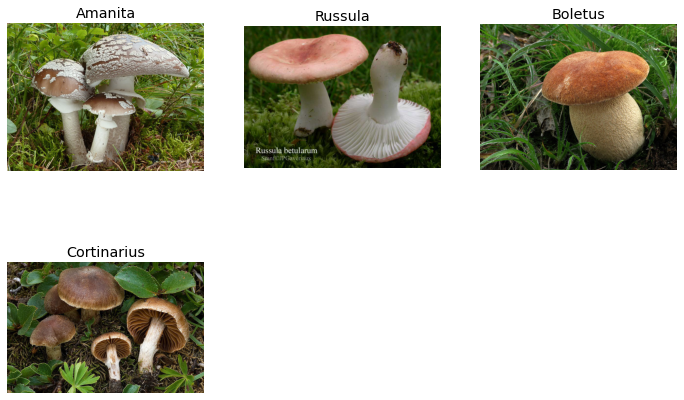

In [ ]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0

test_path = './Dataset_4c_avg/test/'
train_path = './Dataset_4c_avg/train/'

k = 0
for subfolder in os.listdir(test_path):
    
    k = k + 1
    image_file = os.listdir(os.path.join(test_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(test_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

class_number = k
print(f"Class used: {class_number}")

In [ ]:
from tensorflow.python import data
# Create image datasets
train_data = image_dataset_from_directory(train_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    subset='training', validation_split=0.2, seed=1234)

validation_data = image_dataset_from_directory(train_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    subset='validation', validation_split=0.2, seed=1234)

test_data = image_dataset_from_directory(test_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

print(f"Prima: {train_data} \n")
train_data = preprocess_input(train_data)
print(f"Dopo: {train_data}")

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=test_path,
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Found 3424 files belonging to 4 classes.
Using 2740 files for training.
Found 3424 files belonging to 4 classes.
Using 684 files for validation.
Found 382 files belonging to 4 classes.
Prima: <BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 

Dopo: <BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Found 382 images belonging to 4 classes.


**FEATURES EXTRACTION**


In [ ]:
# Pretrained EfficientNetB7 image classification model without final layers
feature_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')

feature_model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 299, 299, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (

In [ ]:
# tf.keras.utils.plot_model(feature_model)

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.3, 0.3)
])

In [ ]:
# Construct a new model with the final dense layer for 9 classes
new_model = tf.keras.models.Sequential(
    [
        data_augmentation,
        feature_model,
        tf.keras.layers.Dropout(0.28),
        tf.keras.layers.Dense(class_number, activation='softmax')   
    ]
)

In [ ]:
# Make all the layers from the original ResNet model untrainable
new_model.layers[1].trainable = False

In [ ]:
# Metrics and optimizer
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Check the architecture of the new model
new_model.build((None, IMG_SIZE, IMG_SIZE, 3))
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 4)                 10244     
                                                                 
Total params: 64,107,931
Trainable params: 10,244
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
# Callbacks to be exercised during training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [ ]:
dir_name = "/content/drive/Shareddrives/Progetto_CIDL/Models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'CNN_pretrained_EfficientNetB7.h5')

callbacks_list = [
    earlystopping,
    reduce_lr,
    tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    include_optimizer=False,
    verbose=1,
    save_best_only=True)
]

# Train new model:
history = new_model.fit(train_data,
                        validation_data=validation_data,
                        epochs=30,
                        verbose=1,
                        callbacks=callbacks_list,
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/30


43/43 [==============================] - ETA: 0s - loss: 0.9994 - accuracy: 0.5803
Epoch 1: val_loss improved from inf to 0.74636, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_EfficientNetB7.h5
43/43 [==============================] - 75s 1s/step - loss: 0.9994 - accuracy: 0.5803 - val_loss: 0.7464 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7387
Epoch 2: val_loss improved from 0.74636 to 0.62341, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_EfficientNetB7.h5
43/43 [==============================] - 40s 913ms/step - loss: 0.7178 - accuracy: 0.7387 - val_loss: 0.6234 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.7803
Epoch 3: val_loss improved from 0.62341 to 0.57035, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_EfficientNetB7

# Displaying the results

In [ ]:
loss, accuracy = new_model.evaluate(test_data,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 3s - loss: 0.4868 - accuracy: 0.8089 - 3s/epoch - 252ms/step
Model performance on test images:
Accuracy = 0.8089005351066589
Loss = 0.48677387833595276


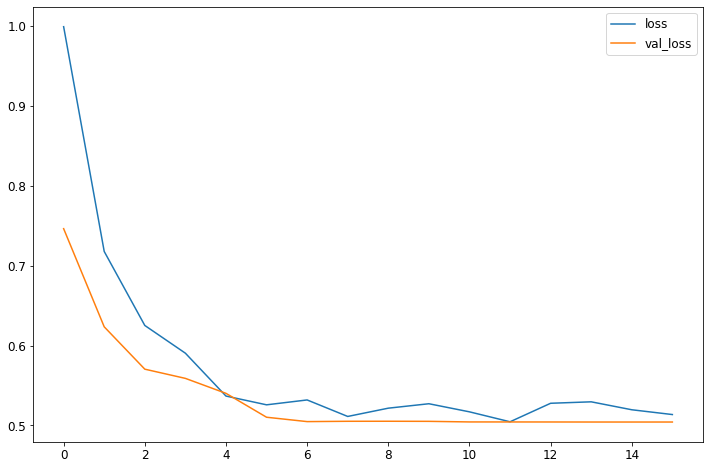

In [ ]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

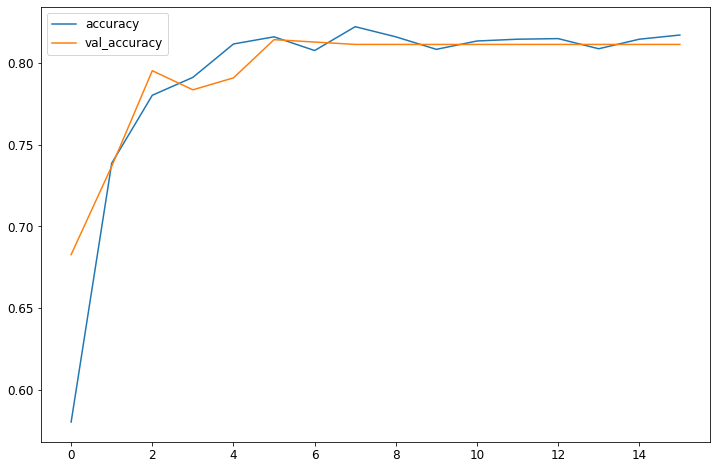

In [ ]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
type(train_data.class_names)

list

<ipython-input-26-33cc9dd81a84>:24: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)


Confusion Matrix
[[ 65   3   1   6]
 [  0 108   0   0]
 [  6  15  39  24]
 [  2  14   3  96]]
Classification Report
              precision    recall  f1-score   support

     Amanita       0.89      0.87      0.88        75
     Boletus       0.77      1.00      0.87       108
 Cortinarius       0.91      0.46      0.61        84
     Russula       0.76      0.83      0.80       115

    accuracy                           0.81       382
   macro avg       0.83      0.79      0.79       382
weighted avg       0.82      0.81      0.79       382



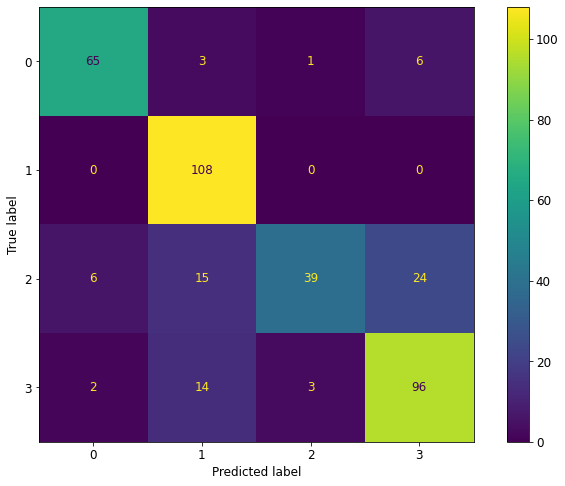

In [ ]:
from pandas.core.dtypes.common import classes
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight


nb_samples = 382 # number of test images
Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
# x is true class, y is predicted class-- middle diagonal represents the accurate predictions

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

**FINE TUNING**

In [ ]:
feature_model.trainable = True

set_trainable = False
for layer in feature_model.layers:
    if layer.name == 'top_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Metrics and optimizer
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 4)                 10244     
                                                                 
Total params: 64,107,931
Trainable params: 1,653,764
Non-trainable params: 62,454,167
_________________________________________________________________


In [ ]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

callbacks_list = [
    earlystopping,
    reduce_lr,
    tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    include_optimizer=False,
    verbose=1,
    save_best_only=True)
]

In [ ]:
# Train new model:
history = new_model.fit(train_data,
                        validation_data=validation_data,
                        epochs=30,
                        verbose=1,
                        callbacks=callbacks_list,
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9259
Epoch 1: val_loss improved from inf to 0.23839, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_EfficientNetB7.h5
43/43 [==============================] - 40s 926ms/step - loss: 0.1938 - accuracy: 0.9259 - val_loss: 0.2384 - val_accuracy: 0.9108 - lr: 1.0000e-04
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9175
Epoch 2: val_loss improved from 0.23839 to 0.21284, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_EfficientNetB7.h5
43/43 [==============================] - 40s 917ms/step - loss: 0.2210 - accuracy: 0.9175 - val_loss: 0.2128 - val_accuracy: 0.9152 - lr: 1.0000e-04
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9299
Epoch 3: val_loss did not improve from 0.21284
43/43 [==============================] - 36s 819ms/step - loss: 0.2003 - accu

In [ ]:
loss, accuracy = new_model.evaluate(test_data,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 2s - loss: 0.1496 - accuracy: 0.9529 - 2s/epoch - 156ms/step
Model performance on test images:
Accuracy = 0.9528796076774597
Loss = 0.1496327817440033


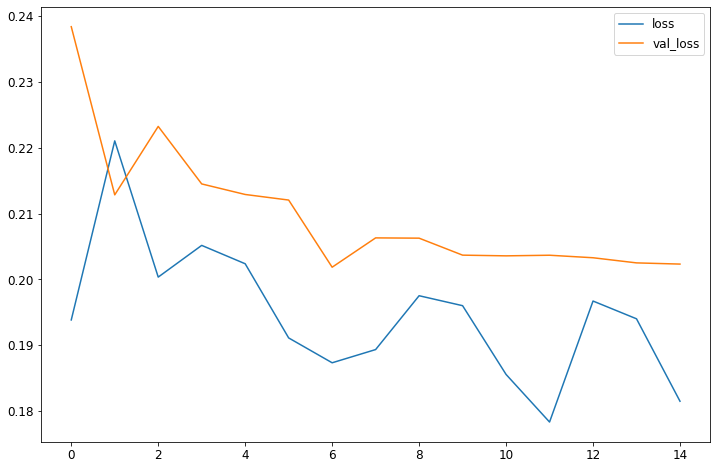

In [ ]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

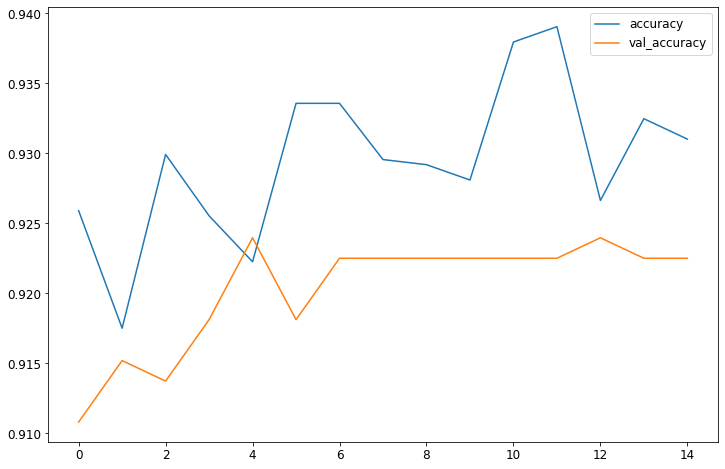

In [ ]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
print(test_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<ipython-input-38-fbc2ae139983>:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)


Confusion Matrix
[[ 71   0   1   3]
 [  0 108   0   0]
 [  3   3  74   4]
 [  1   2   0 112]]
Classification Report
              precision    recall  f1-score   support

     Amanita       0.95      0.95      0.95        75
     Boletus       0.96      1.00      0.98       108
 Cortinarius       0.99      0.88      0.93        84
     Russula       0.94      0.97      0.96       115

    accuracy                           0.96       382
   macro avg       0.96      0.95      0.95       382
weighted avg       0.96      0.96      0.96       382



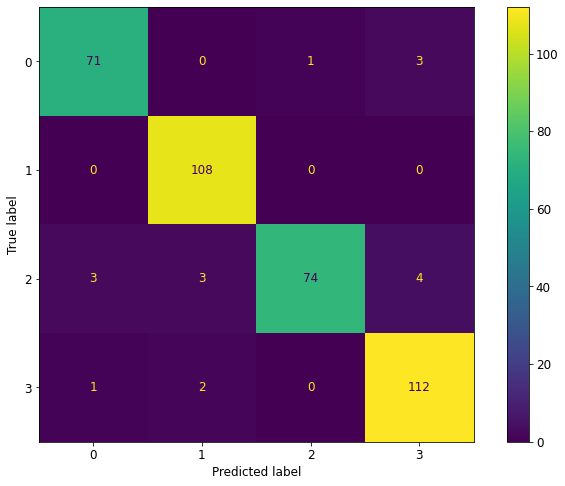

In [ ]:
from pandas.core.dtypes.common import classes
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight


nb_samples = 382 # number of test images
Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
# x is true class, y is predicted class-- middle diagonal represents the accurate predictions

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()